# housing_project

fetch data

In [176]:
import os
import tarfile
import urllib
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import CategoricalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.externals import joblib

In [115]:
downdload_root = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
housing_path = os.path.join("datasets", "housing","")
housing_url = downdload_root + housing_path + "housing.tgz"
print(housing_url)

def fetch_housing_data(housing_url=housing_url, housing_path=housing_path, housing_tgz="housing.tgz"):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    tgz_path = os.path.join(housing_path, housing_tgz)
    if not os.path.isfile (tgz_path):
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

def load_housing_data(housing_path = housing_path, housing_csv="housing.csv"):
    csv_path = os.path.join(housing_path, housing_csv)
    return pd.read_csv(csv_path)


https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz


CombineAttributeAdder class

In [116]:
class CombineAttributeAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

class CategoricalEncoder(OneHotEncoder, BaseEstimator, TransformerMixin):
    def __init__(self,dataframe):
        self.encoder = OneHotEncoder()
        self.dataframe = dataframe
        self.attribute = attribute
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        cat = self.dataframe[self.attribute]
        cat_encoded, cat_categories = cat.factorize()
        return encoder.fit_transform(X.reshape(-1,1))

In [117]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [155]:
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [118]:
fetch_housing_data(housing_url=housing_url, housing_path=housing_path)
housing_df = load_housing_data(housing_path)

In [119]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Stratify median_income's wide range for better train and test split

In [120]:
housing_df["income_cat"] = np.ceil(housing_df["median_income"]/1.5)
housing_df["income_cat"].where(housing_df["income_cat"]<5, 5.0, inplace=True)

create train and test set

In [121]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
housing_df = strat_train_set.copy()

Check the data

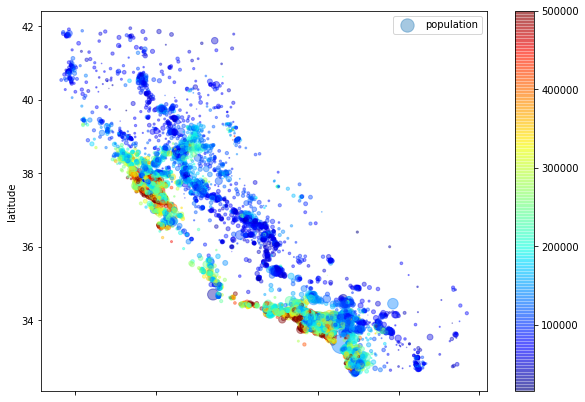

In [122]:
housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),
    s=housing_df["population"]/100, label="population",
    c=housing_df["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True)

Investigate correlation

In [123]:
corr_matrix = housing_df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Separate numeric and categorical attributes

In [125]:
housing_num = housing_df.drop("ocean_proximity", axis=1)
housing_num.drop("median_house_value", axis=1, inplace=True)
housing_cat = housing_df["ocean_proximity"]

In [126]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [127]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombineAttributeAdder()),
    ('std_scaler', StandardScaler())
])

In [128]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
])

In [129]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [130]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [131]:
housing_label = housing_df["median_house_value"]
housing_df.drop("median_house_value", axis=1, inplace=True)

In [132]:

list(num_attribs)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [133]:
housing_prepared = full_pipeline.fit_transform(housing_df)

In [134]:
housing_prepared.shape

(16512, 16)

In [135]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [136]:
some_data = housing_df.iloc[:5]
some_labels = housing_label.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [138]:
lin_reg.predict(some_data_prepared)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [139]:
list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

In [141]:
housing_predictions = lin_reg.predict(housing_prepared)

In [143]:
lin_mse = mean_squared_error(housing_label, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

In [144]:
lin_rmse

68628.19819848922

In [159]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798348


In [146]:
tree_reg = DecisionTreeRegressor()

In [147]:
tree_reg.fit(housing_prepared, housing_label)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [148]:
housing_treereg_predictions = tree_reg.predict(housing_prepared) 

In [149]:
tree_mse = mean_squared_error(housing_label, housing_treereg_predictions)

In [150]:
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [154]:
scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [156]:
display_scores(tree_rmse_scores)

Scores:  [69118.27813036 66916.23634158 69113.40542533 70392.27209604
 72068.19919014 74677.25111333 70719.582342   72594.86214084
 76696.6496712  70169.16330661]
Mean:  71246.58997574223
Standard deviation:  2719.6702117090017


In [162]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [165]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_label, scoring="neg_mean_squared_error", cv=10)

In [166]:
forest_rmse_score = np.sqrt(-forest_scores)
display_scores(forest_rmse_score)

Scores:  [52796.24060347 49948.68086651 51263.96809787 55682.57232816
 52095.87851296 55749.03817362 51108.28978775 51672.48786103
 55164.52560746 52227.15429219]
Mean:  52770.88361310129
Standard deviation:  1950.258658812221


In [167]:
forest_reg.predict(some_data_prepared)

array([267390., 306560., 197480.,  55690., 236060.])

In [168]:
list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

In [171]:
joblib.dump(lin_reg, "housing_lin_reg.pkl")

['housing_lin_reg.pkl']

In [172]:
joblib.dump(tree_reg, "housing_tree_reg.pkl")

['housing_tree_reg.pkl']

In [173]:
joblib.dump(forest_reg, "housing_forest_reg.pkl")

['housing_forest_reg.pkl']

In [175]:
house_predict_model = joblib.load("housing_forest_reg.pkl")

In [186]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

In [187]:
forest_reg = RandomForestRegressor()

In [188]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [192]:
best_model = grid_search.fit(housing_prepared, housing_label)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [190]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [191]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [193]:
best_model.predict(some_data_prepared)

array([260156.66666667, 332546.66666667, 229210.        ,  49586.66666667,
       239266.66666667])

In [194]:
list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

In [196]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [197]:
X_test_prepared = full_pipeline.transform(X_test)

In [198]:
final_predictions = best_model.predict(X_test_prepared)

In [199]:
final_mse=mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [200]:
print(final_rmse)

47984.89912049514
